<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Neural Networks and Backpropagation

_Authors: Kiefer Katovich (SF)_

---

### Learning Objective
- Learn what a neural network is. 
- Visualize a simple feedforward neural network.
- Code the forward propagation algorithm.
- Understand the math behind neural network fitting and backpropagation.
- Code a class for a simple neural network by hand!
- Understand the concept of activation functions and the sigmoid activation.
- Test out the custom neural network class on the XOR problem.

### Lesson Guide
- [Visualizing a simple feedforward neural network](#visualizing-a-simple-feedforward-neural-network)
- [Initializing the neurons with numpy](#initializing-the-neurons-with-numpy)
- [Equation for neuron activation](#equation-for-neuron-activation)
	- [Matrix algebra notation](#matrix-algebra-notation)
- [Coding the forward propagation](#coding-the-forward-propagation)
	- [Linear activation function](#linear-activation-function)
	- [Function for the activation of a single neuron](#function-for-the-activation-of-a-single-neuron)
	- [Function to compute layer-to-layer forward propagation](#function-to-compute-layer-to-layer-forward-propagation)
	- [Matrix algebra version of forward propagation](#matrix-algebra-version-of-forward-propagation)
- [The XOR problem](#the-xor-problem)
	- [Loss function](#loss-function)
- [Backpropagation: adjusting parameters in a direction that reduces loss](#backpropagation-adjusting-parameters-in-a-direction-that-reduces-loss)
	- [A very simple network](#a-very-simple-network)
	- [Derivative of error with respect to parameters](#derivative-of-error-with-respect-to-parameters)
- [The chain rule of calculus](#the-chain-rule-of-calculus)
- [Error of a single neuron](#error-of-a-single-neuron)
- [Error of the output layer](#error-of-the-output-layer)
	- [Calculate the error of the output layer](#calculate-the-error-of-the-output-layer)
- [Calculating error of a layer using the error of the following layer](#calculating-error-of-a-layer-using-the-error-of-the-following-layer)
- [Rate of change of cost with respect to bias](#rate-of-change-of-cost-with-respect-to-bias)
- [Rate of change of cost with respect to weights](#rate-of-change-of-cost-with-respect-to-weights)
- [Putting it all together into a neural network](#putting-it-all-together-into-a-neural-network)
	- [Initialization](#initialization)
	- [The sigmoid actiation function](#the-sigmoid-actiation-function)
	- [Code the forward propagation](#code-the-forward-propagation)
	- [Implement the backpropagation step](#implement-the-backpropagation-step)
	- [Implement a fit function](#implement-a-fit-function)
- [Test the custom network on the XOR problem](#test-the-custom-network-on-the-xor-problem)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def draw_neural_net(ax, layer_sizes, layer_activations=None, weights=None,
                    left=0.1, right=0.9, bottom=0.1, top=0.9):
    '''
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(max(layer_sizes), 2))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in xrange(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            if layer_activations is not None:
                act = layer_activations[n][m]
                if not isinstance(act, str):
                    act = "{0:.2f}".format(act)
                    fontsize = 14
                else:
                    fontsize = 18
                ax.text(n*h_spacing + left, layer_top - m*v_spacing,
                        act, ha='center', va='center', zorder=5, fontsize=fontsize)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in xrange(layer_size_a):
            for o in xrange(layer_size_b):
                color = 'k'
                lw = 2.
                if weights is not None:
                    W = weights[n]
                    if len(W.shape) == 2:
                        w = W[m, o]
                    else:
                        w = W[o]
                    if w < 0:
                        color = 'darkred'
                    lw = 0.5 + 2*np.abs(w)
                    
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], 
                                  c=color, lw=lw)
                ax.add_artist(line)

<a id="visualizing-a-simple-feedforward-neural-network"></a>
## Visualizing a simple feedforward neural network
---

The chart below shows a simple feedforward neural network. There are three layers in this network:
- The **input** layer (2 neurons)
- The **hidden** layer (3 neurons)
- The **output** layer (1 neuron)

This is a *fully connected* feedforward network. That means that there are connections from each neuron in one layer to every neuron in the following layer. Note that there are not connections from the input layer to the output layer.

The connections between the layers are **weights**. The very high-level behavior of this neural network is that the "activation" in a a neuron is multiplied by the weights and that new value is passed forward to the next neuron. When there are multiple incoming connections to a neuron, the weighted activations are summed together.

Using neural networks for machine learning tasks, the input neurons are given the value of our predictors. The output layer will represent the prediction (or predictions if there are multiple neurons in the output layer!) of the target. 

Like with other models, we evaluate the error of the prediction against the true target. Neural networks are fit (their weights adjusted to optimal values) through the process of **backpropagation**. Backpropagation is gradient descent for the parameters (with parameters represented as the weights). The details of backprogagation are covered in this lesson.

There are some other nuances like **activation functions** that I have not included in this high level introduction, but we will examine them soon.

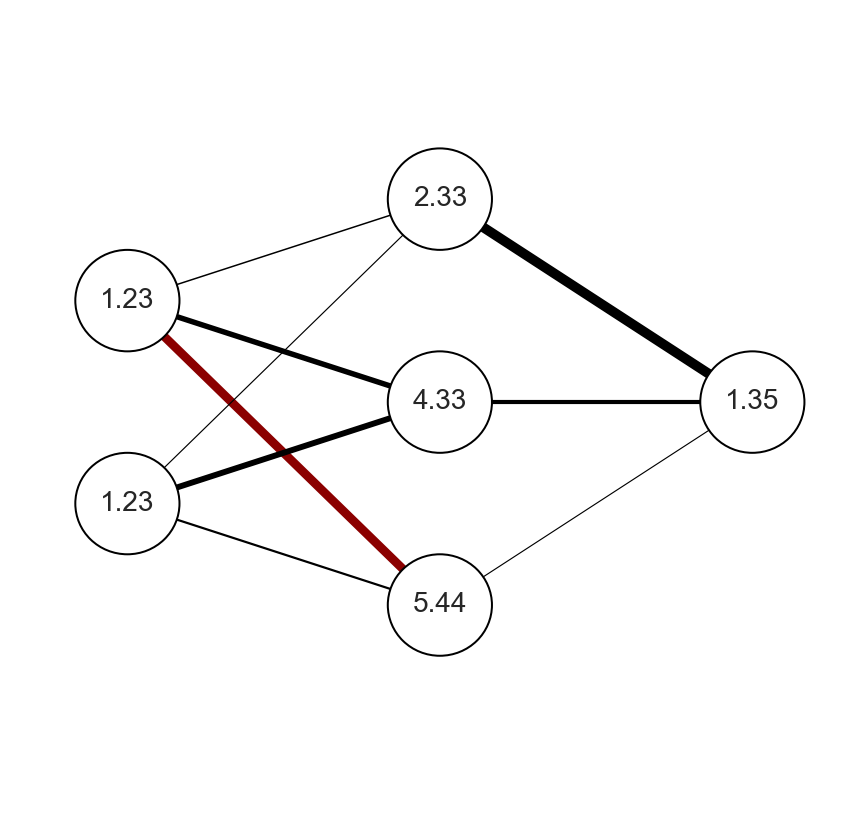

In [3]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis('off')
draw_neural_net(ax, [2, 3, 1], layer_activations=[[1.23, 1.23], 
                                                  [2.33, 4.33, 5.44], 
                                                  [1.34555]],
                weights=[np.random.normal(0,1, size=(2,3)), 
                         np.random.normal(0,1, size=(3,1))])


<a id="initializing-the-neurons-with-numpy"></a>
## Initializing the neurons with numpy
---

We can start to build this simple neural network using numpy:

In [4]:
input_act = np.zeros(2)
hidden_act = np.zeros(3)
output_act = np.zeros(1)

print input_act, hidden_act, output_act

[0. 0.] [0. 0. 0.] [0.]


<a id="equation-for-neuron-activation"></a>
## Equation for neuron activation 
---

We can write the equation for the activation of the $j$th neuron in the $i$th layer as:

### $$ a_j^i = \sigma \left( \sum_k w_{jk}^i a_k^{i-1} + b_j^i \right)$$

There is a decent amount going on in this equation. We will examine the pieces.

- $a_j^i$ represents the activation of the $j$th neuron in the $i$th layer. Note that the superscript corresponds to the layer number and the subscript corresponds to the neuron number within the layer.

- $a_k^{i-1}$ is the activation of the $k$th neuron in the $i-1$th layer.

- $\sigma$ represents an "activation function". More on this later, but it is a function that can transform the activation of neurons. The simplest activation function is the linear activation, $f(x) = x$.

- $w_{jk}^i$ represents the weight of the activation in the $k$th neuron in the $i-1$ layer to the $j$th neuron in the $i$th layer. So, $j$ is the destination neuron in the $i$ layer. $k$ is the departure neuron in the previous layer.

- $b_j^i$ is the "bias" of the $j$th neuron in the $i$th layer. The bias adds a constant to the value of the activation.

The gist of the equation is that each neuron is a sum of the weighted activations of neurons that feed into it plus a "bias" value, all fed through a final activation function.


<a id="matrix-algebra-notation"></a>
### Matrix algebra notation

The formula becomes cleaner in matrix notation. Here is the vectorized version of the formula above:

### $$ a^i = \sigma(W^i a^{i-1} + b^i) $$

Now there is a weight matrix $W^i$ for each layer $i$. The weight matrix defines the weightings on the previous layer neuron activations to the neurons of the current layer. 

<a id="coding-the-forward-propagation"></a>
## Coding the forward propagation
---

We can manually demo how the activations are propagated forward through the network using our simple architecture. We will do this with the element-wise and linear algebraic formula both for clarity.
    
<a id="linear-activation-function"></a>
### Linear activation function

First off, let's code the linear activation function. This is the most basic activation function and literally just returns the input as output.

### $$ f(x) = x $$

In [5]:
def linear(x):
    return x

<a id="function-for-the-activation-of-a-single-neuron"></a>
### Function for the activation of a single neuron

We can write a function to calculate the activation of a **single** neuron given arguments:

    neurons
    neuron_weights
    bias
    activation_func

According to the formula outlined above.

In [6]:
def single_activation(neurons, neuron_weights, bias, activation_func=linear):
    activation = 0.
    for n, w in zip(neurons, neuron_weights):
        activation += n*w
    activation += bias
    activation = activation_func(activation)
    return activation
    

**Test out the activation function on a set of input neurons, weights, and bias.**

In [7]:
single_activation([1.,2.,3.], [0.5, 0.5, 0.5], bias=10.)

13.0

**We can visualize our test using the plotting function as well.**

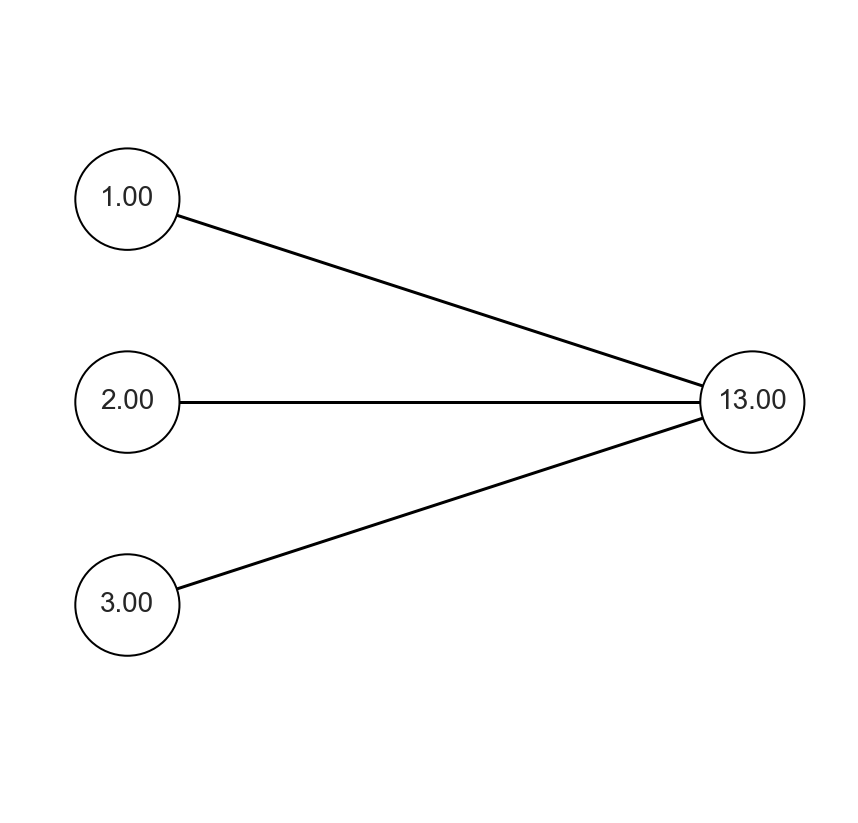

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis('off')
draw_neural_net(ax, [3, 1], layer_activations=np.array([[1,2,3],[13]]),
                weights=np.array([[0.5, 0.5, 0.5]]))

<a id="function-to-compute-layer-to-layer-forward-propagation"></a>
### Function to compute layer-to-layer forward propagation

Having the function to calculate activation for a single neuron, we can write a function to calculate an entire layer-to-layer forward propagation. This function will accept arguments:

    layer_in
    in_out_weights
    layer_out_biases
    activation_function
    
The `in_out_weights` will be a matrix or list of lists that specifies the weightings for each of the input neuron activations to all of the neurons in the output layer. The biases will be a vector the same length as the output layer.

Assume that the layers in and out are represented as 1D vectors.

In [9]:
def layer_activation(layer_in, in_out_weights, out_biases, activation_func=linear):
    activations = np.zeros(in_out_weights.shape[1])
    print 'initial activations:', activations
    for col in range(in_out_weights.shape[1]):
        current_weights = in_out_weights[:, col]
        print 'current weights:', current_weights
        current_bias = out_biases[col]
        activations[col] = single_activation(layer_in, current_weights, current_bias,
                                             activation_func=activation_func)
    return activations

**We can test it out below. Initialize the inputs, weights, and biases to calculate the hidden layer:**

In [10]:
input_act = np.random.uniform(-1, 1, size=2)
input_to_hidden = np.random.randn(2, 3)
hidden_biases = np.ones(3)

print input_act
print input_to_hidden
print hidden_biases

[-0.43467042 -0.8969043 ]
[[-0.30405042 -0.97280051 -1.13353324]
 [ 0.90450323  0.47001421 -0.23197764]]
[1. 1. 1.]


In [11]:
hidden_act = layer_activation(input_act, input_to_hidden, hidden_biases)
hidden_act

initial activations: [0. 0. 0.]
current weights: [-0.30405042  0.90450323]
current weights: [-0.97280051  0.47001421]
current weights: [-1.13353324 -0.23197764]


array([0.32090888, 1.00128984, 1.70077511])

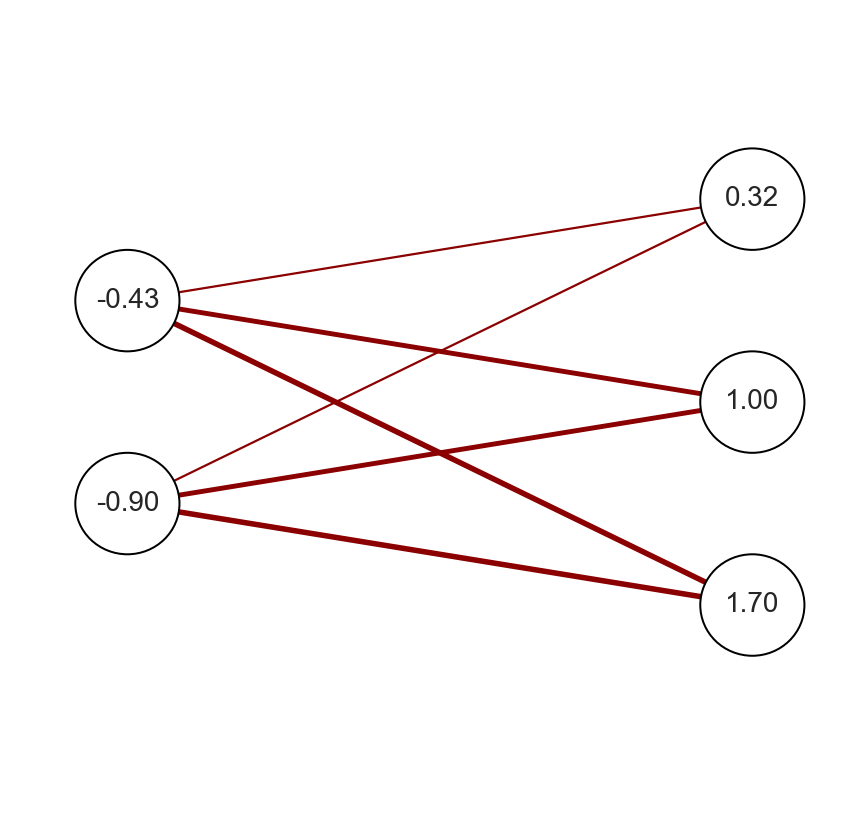

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis('off')
draw_neural_net(ax, [2, 3], layer_activations=[input_act, hidden_act],
                weights=input_to_hidden)


**You can do the same for the hidden layer to the output layer.**

Initialize the hidden to output weights as well as the bias for the output weights, then you can use the function again.

In [13]:
hidden_to_output = np.random.randn(3,1)
print hidden_to_output
output_bias = np.array([-1])
print output_bias

[[ 0.28570415]
 [ 1.23965114]
 [-0.03356812]]
[-1]


In [14]:
print hidden_act
print hidden_to_output.T[0]
print hidden_act * hidden_to_output.T[0]
print np.sum(hidden_act * hidden_to_output.T[0])
print np.sum(hidden_act * hidden_to_output.T[0]) -1

[0.32090888 1.00128984 1.70077511]
[ 0.28570415  1.23965114 -0.03356812]
[ 0.091685    1.2412501  -0.05709183]
1.2758432697642428
0.2758432697642428


In [15]:
np.sum(hidden_act*hidden_to_output.T) -1 

0.2758432697642428

In [16]:
output_act = layer_activation(hidden_act, hidden_to_output, output_bias)
output_act

initial activations: [0.]
current weights: [ 0.28570415  1.23965114 -0.03356812]


array([0.27584327])

<a id="matrix-algebra-version-of-forward-propagation"></a>
### Matrix algebra version of forward propagation

Recall the "vectorized" formulation of the forward propagation:

### $$ a^i = \sigma(W^i a^{i-1} + b^i) $$

$a$ are vectors of neuron activations for layer $i$, the $b$ is now a vector of biases, and $W$ indicates our weight matrix.

We can also define just the weighted input - the vector that is fed to the activation function - as a vector $z$:

### $$ z^i = (W^i a^{i-1} + b^i) $$

Write the forward propagation functions above but using matrix operations. Define a function that will take the input layer, weight matrix, biases, and activation function and calculate the activations with linear algebra operations.

In [17]:
input_to_hidden

array([[ 0.29880185, -2.24463554,  0.78856987],
       [ 0.00297998, -1.38147537, -1.16544197]])

In [18]:
np.atleast_2d(input_act)

array([[ 0.17963578,  0.91807199]])

In [19]:
input_act.dot(input_to_hidden)

array([ 0.05641134, -1.6715107 , -0.92830426])

In [20]:
def forward(input_layer, weights, biases, activation_function=linear):
    input_rows = np.atleast_2d(input_layer)
    
    # calculate output layer activations
    output_activations = activation_function(input_rows.dot(weights) + biases)
    
    return output_activations

You can see that this gives us the same result as above. This way of writing it will come in handy when you want to apply the operation to multiple observations of inputs at once.

In [21]:
hidden_act = forward(input_act, input_to_hidden, hidden_biases)
hidden_act

array([[ 1.05641134, -0.6715107 ,  0.07169574]])

In [22]:
output_act = forward(hidden_act, hidden_to_output, output_bias)
output_act

array([[-0.48735809]])

We can plot this out again with the activations for clarity.

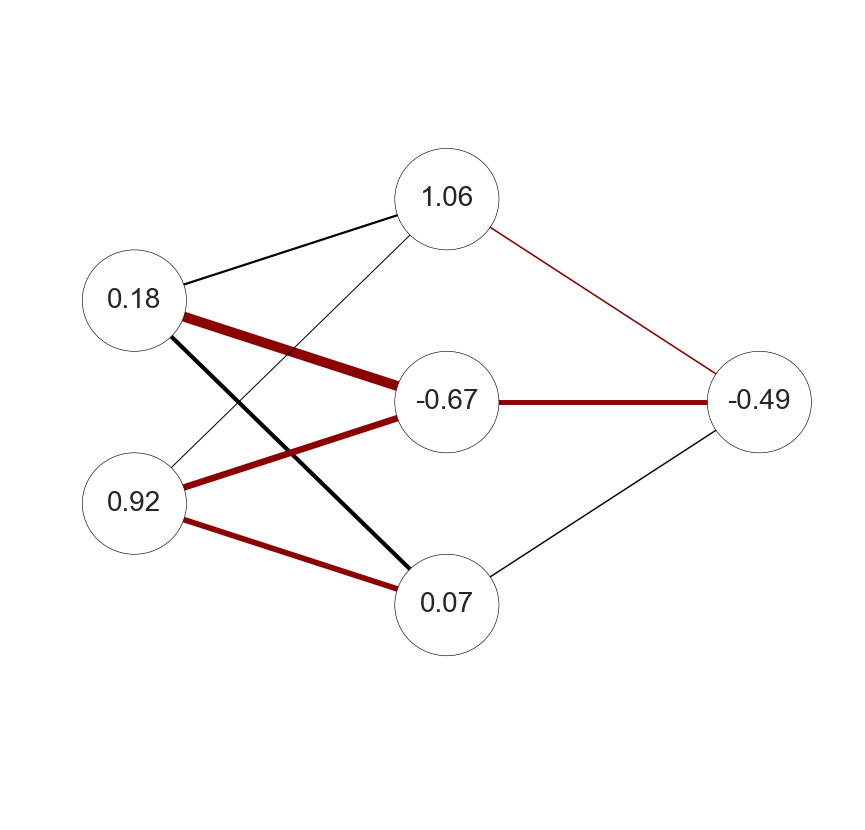

In [23]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis('off')
draw_neural_net(ax, [2, 3, 1], layer_activations=[input_act, hidden_act[0], output_act[0]],
                weights=[input_to_hidden, hidden_to_output])


<a id="the-xor-problem"></a>
## The XOR problem
---

Thus far, our network is not terribly interesting or useful. Let's introduce a problem to solve with our neural network.

The XOR problem is a classic problem for neural networks. XOR is the symbol for "exclusive or", which is a logical operation that evaluates to `True` when A or B is present, but not both. 

Let's set up our "data" below, with the inputs to XOR and our expected output.

In [24]:
XOR_in = np.array([[1,1],[1,0],[0,1],[0,0]])
XOR_out = np.array([[0,1,1,0]]).T

print XOR_in
print XOR_out

[[1 1]
 [1 0]
 [0 1]
 [0 0]]
[[0]
 [1]
 [1]
 [0]]


<a id="loss-function"></a>
### Loss function

We will also need to specify a loss function. For now let's use the least squared loss, which we will code below.

In [25]:
def lsq_loss(y_true, y_pred):
    return np.mean(0.5 * (y_true - y_pred)**2)

What would be our loss right now, if we fed the inputs into the neural network?

We can put it through our function above to see.

In [26]:
def forward_pass(input_layer, weights_list, biases_list):
    activations = [input_layer]
    for W, b in zip(weights_list, biases_list):
        activations.append(forward(activations[-1], W, b))
    return activations

In [27]:
acts = forward_pass(XOR_in, [input_to_hidden, hidden_to_output], [hidden_biases, output_bias])

In [28]:
for a in acts:
    print a

[[1 1]
 [1 0]
 [0 1]
 [0 0]]
[[ 1.30178183 -2.62611091  0.62312789]
 [ 1.29880185 -1.24463554  1.78856987]
 [ 1.00297998 -0.38147537 -0.16544197]
 [ 1.          1.          1.        ]]
[[ 1.44637631]
 [ 0.22224319]
 [-0.78853785]
 [-2.01267097]]


In [29]:
XOR_out

array([[0],
       [1],
       [1],
       [0]])

In [30]:
hidden_to_output.T

array([[-0.14304674, -0.97699162,  0.10736739]])

You'll notice that these are now for each observation.


In [31]:
'MSE loss:', lsq_loss(XOR_out, acts[-1])

('MSE loss:', 1.2433277739302464)

<a id="backpropagation-adjusting-parameters-in-a-direction-that-reduces-loss"></a>
## Backpropagation: adjusting parameters in a direction that reduces loss
---

We would like to reduce our error on prediction. In order to do this, we will have to adjust the weights in our network. Backpropagation of error is the method in which neural networks adjust these weights. 

The crux of backpropagation is that we calculate the partial derivative of the cost function (loss function) with respect to weights and biases. This is the same idea of gradient descent, where we incrementally tweak the values of coefficients down the gradient towards the minimum of the loss function. The only difficulty is that we now have layered coefficients and the derivative with respect to any one of them may be intractable to explicitly derive.

Luckily, backpropagation allows us to avoid deriving the full derivative of the cost function with respect to any given parameter. It leverages the chain rule of calculus to find the gradient through an iterative procedure.

<a id="a-very-simple-network"></a>
### A very simple network 

To simplify things starting out, let's look at an even more basic neural network architecture. Now we have 3 layers, but only one node in each one:


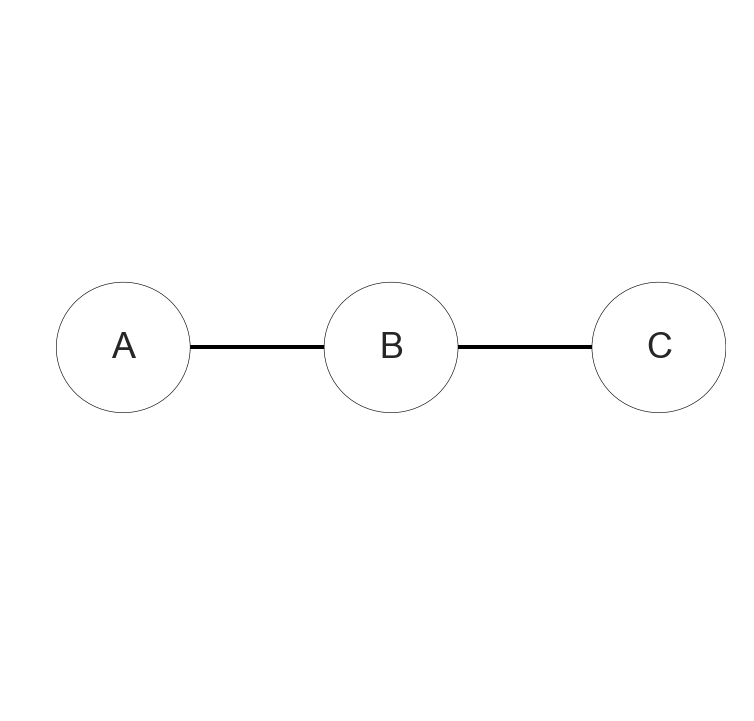

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
draw_neural_net(ax, [1, 1, 1], layer_activations=[['A'],['B'],['C']])


<a id="derivative-of-error-with-respect-to-parameters"></a>
### Derivative of error with respect to parameters

Say $MSE_x$ is our loss function for a single training example, we want to calculate:

### $$ \frac{\partial MSE_x}{\partial w} \\
\frac{\partial MSE_x}{\partial b} $$

Where $w$ are the weights between the neurons and $b$ are the biases. These partial derivatives will inform us how to adjust the values like in gradient descent to minimize the loss function.

We may have many observations - in the case of our XOR problem we have 4. Luckily we can recover the partial derivative of the entire cost function with respect to $w$ and $b$ by averaging over the input training samples. This is because our least squared loss function can be described as an average loss across the training examples.

Backpropagation is really about the backpropagation of the total error of the network (as defined by the loss/cost function) through to the neurons. One way of thinking about this is that each neuron will be assigned an amount of error that it is contributing to the overall error.

<a id="the-chain-rule-of-calculus"></a>
## The chain rule of calculus
---

The key to how backpropagation works lies in the chain rule. The chain rule is a method to compute the derivatives of functions that are compositions of other functions with known derivatives.

Say we have two functions, $f$ and $g$, and that we define variables $y$ and $z$ such that:

### $$ y = g(x) \\
z = f(g(x)) = f(y) $$

Where $x$ is a real number. These are functions that map real numbers to other real numbers, and they represent a dependent relationship. Specifically, the value of $z$ is dependent on the value of $y$. The chain rule is written as:

### $$ \frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \cdot \frac{\partial y}{\partial x} $$

Take our simple neural network we plotted above with neurons A, B, and C. We can write out some formulas for the activations of these neurons:

### $$ a_B(x) = \sigma (a_A(x) \cdot W_{AB} + b_{B}) \\
a_C(x) = \sigma (a_B(x) \cdot W_{BC} + b_{C})$$

So, therefore:

### $$ a_C(x) = \sigma (\sigma (a_A(x) \cdot W_{AB} + b_{B}) \cdot W_{BC} + b_{C}) $$

And:

### $$ \frac{\partial C}{x} = \frac{\partial C}{\partial B} \frac{\partial B}{\partial A} \frac{\partial A}{\partial x} $$

We have the dependent function relationship defined in the chain rule above.

<a id="error-of-a-single-neuron"></a>
## Error of a single neuron
---

We can define the error of a neuron $j$ as:

### $$ \partial_j^i = \frac{\partial C}{\partial a_j^i} $$

Where $a_j^i$ is the activation of the neuron *before* we apply the activation function $\sigma$.

$C$ here represents the cost, or total error of the network. The entire right hand side of the equation represents the partial derivative of the loss with respect to the weighted input of neuron $j$ at layer $i$.


<a id="error-of-the-output-layer"></a>
## Error of the output layer
---

In backpropagation we will work backwards from the output layer down, computing the error with derivatives at each step. 

The first step is to calculate the error of our output neurons. The error will be the derivative of our cost $C$ with respect to the activation multiplied by the derivative our our activation function applied to the pre-function activation of our neurons $z_j^i$. The full formula is written as:

### $$ \partial_j^{out} = \frac{\partial C}{\partial a_j^{out}} \sigma' (z_j^{out}) $$

- $\partial_j^{out}$ are the errors for each of the $j$ output nodes. In our case, there is just one output node, so we will just have $\partial^{out}$

- $\frac{\partial C}{\partial a_j^{out}}$ is the derivative of the cost with respect to the activations of the output neurons. Again, we only have a single output neuron.

- $\sigma' (z_j^{out})$ is the derivative of the activation function applied to the weighted inputs to the neurons. We are using a linear activation function, and it's derivative evaluates to 1 regardless of input:

### $$ \text{linear}'(x) = 1 $$

For our simple neural network with a single output, we can simplify the equation:

### $$ \partial^{out} = \frac{\partial C}{\partial a^{out}}$$

This formula is derived using the chain rule:

### $$ \partial_j^{out} = \frac{\partial C}{\partial a_j^{out}} \frac{\partial a_j^{out}}{\partial z_j^{out}} = \frac{\partial C}{\partial a_j^{out}} \sigma' (z_j^{out}) $$

Since, 

### $$ a_j^{out} = \sigma (z_j^{out}) \\
\sigma' (z_j^{out}) = \frac{\partial a_j^{out}}{\partial z_j^{out}} $$


Our error is the derivative of the loss with respect to the output activation. Because we are using the least squares loss function (remember, we multiplied it by 0.5 earlier to cancel out the exponent in the derivative), we can further simplify this to:

### $$ \partial^{out} = - (y - a^{out}) \\
\partial^{out} = a^{out} - y  $$


<a id="calculate-the-error-of-the-output-layer"></a>
### Calculate the error of the output layer

Let's calculate the error of our output layer. We will need to write a function that calculates the derivative of the loss function.

In [33]:
def lsq_prime(y_true, y_hat):
    return np.mean(y_hat - y_true)

In [34]:
acts = forward_pass(XOR_in, [input_to_hidden, hidden_to_output], [hidden_biases, output_bias])
out_act = acts[-1]
delta = lsq_prime(XOR_out, out_act)
delta

-0.78314733031076367

<a id="calculating-error-of-a-layer-using-the-error-of-the-following-layer"></a>
## Calculating error of a layer using the error of the following layer
---

Using the error of the output layer, we can calculate the error of the previous (hidden) layer. We can keep doing this for each layer down the line. The equation to calculate the error of a layer from the error of the layer above it is:

### $$ \partial^i = ((W^{i+1})^T \partial^{i+1}) \circ \sigma' (z^i) $$

This is also derived using the chain rule. [The full proof (and a great overview of all the theory this lecture is primarily based on) of this can be found here.](http://neuralnetworksanddeeplearning.com/chap2.html)

The $\circ \sigma' (z^i)$ indicates a "hadamard product" which is an elementwise multiplication. Because we are using the linear activation and our derivative activation function outputs 1, we do not have to worry about this. If you did need to do it, you can use the `np.multiply` function.

With linear activation we can just write this:

### $$ \partial^i = ((W^{i+1})^T \partial^{i+1})$$

The $(W^{i+1})^T \partial^{i+1}$ section of the equation is interesting. It is doing the dot product of the transposed weights and the error from the layer up. The intuition behind this is that we are moving the error down to this layer proportional to the weightings between this layer and the one above.

<a id="rate-of-change-of-cost-with-respect-to-bias"></a>
## Rate of change of cost with respect to bias
---

The derivative of the cost function with respect to the bias for a neuron in a layer is equal to the error of the neuron. This is good news because we have the formula for the error already in the equation above.

### $$ \frac{\partial C}{\partial b_j^i} = \partial_j^i $$


<a id="rate-of-change-of-cost-with-respect-to-weights"></a>
## Rate of change of cost with respect to weights
---

The derivative of the cost function with respect to a weight is calculated with the activation input to that neuron multiplied by the error of the neuron. The equation is:

### $$ \frac{\partial C}{\partial w_{jk}^i} = a_k^{i-1} \partial_j^i $$

Specifically, this states that for weights between neuron $k$ in layer $i-1$ to to the neuron $j$ in layer $i$, the derivative of the cost function with respect to this weight is the activation of the input times the error of the neuron.

More casually:

### $$ \frac{\partial C}{\partial w_{jk}^i} = a_{in} \partial_{out} $$

Where $a_{in}$ is the activation of the neuron on the input side of the weight, and $\partial_{out}$ is the error for the neuron on the output side of the weight.

<a id="putting-it-all-together-into-a-neural-network"></a>
## Putting it all together into a neural network
---

Now that we have all of the equations, we can code a class to build a neural network that will adjust its weights using backpropagation.

1. The class will need a function to perform the _forward_ propagation of the activations through the network given an input. This will give us the activations at each layer for the neurons.
2. We will also need a cost function and its derivative. This is how we will calculate the error of the network from the output layers.
3. Once we have the error of the network, we can create the _backwards_ propagation of this error/gradient from the output layer downwards. Our goal is to calculate the derivative of the cost function with respect to the weights and the biases, which are our parameters.
4. With the derivatives of the cost function of our parameters, we can update the weights and biases according to a learning rate parameter.

<a id="initialization"></a>
### Initialization

First let's set up the network with the input, hidden, and output sizes.

The initialization function needs to create some random weights between the input and hidden layer, the hidden and output layer, as well as create the bias vectors for the hidden and output.

For the bias vectors, I am putting the values in the column dimension to make numpy operations consistent down the line.

In [35]:
class DumbNet(object):
    
    activations = []
    
    def __init__(self, input_size=2, hidden_size=3, output_size=1):
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input_to_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.hidden_to_output = np.random.randn(self.hidden_size, self.output_size)
        
        self.hidden_bias = np.random.uniform(-1, 1, (1, hidden_size))
        self.output_bias = np.random.uniform(-1, 1, (1, output_size))
        

I've also initialized a list `activations` that will store the current forward propagation activations.

We can print out the different initialized matrices to get a feel for the setup:

In [36]:
dn = DumbNet()
print 'input to hidden W:'
print dn.input_to_hidden
print 'hidden to output W:',
print dn.hidden_to_output
print 'hidden bias:'
print dn.hidden_bias
print 'output bias:'
print dn.output_bias

input to hidden W:
[[-0.27139718 -0.30566207 -0.50213509]
 [-0.17114751  0.25278268 -0.83881125]]
hidden to output W: [[-0.71516773]
 [ 0.20930802]
 [-0.78911418]]
hidden bias:
[[-0.17462484 -0.71737495  0.25598798]]
output bias:
[[-0.28811538]]


You can see that rows correspond to the dimensions of inputs and columns the dimensions of outputs for the weights.

<a id="the-sigmoid-actiation-function"></a>
### The sigmoid actiation function

Next we need to code the activation function, loss function, and their derivatives for use in the forward and backward propagation step. Instead of linear activation, we will switch to using a _nonlinear_ activation function, the sigmoid activation. This squishes activation to a value between 0 and 1. 

For the XOR problem this nonlinearity allows the network to converge on the right answer.

The sigmoid activation function is defined:

### $$ \text{sigmoid}(x) = \frac{1}{1 + e^{-x}} $$

Which is the same as the link function in logistic regression.

The derivative of the sigmoid function is:

### $$ \text{sigmoid}'(x) = (1 - \text{sigmoid}(x)) \text{ sigmoid}(x) $$

Below, add the sigmoid activations as well as the least squares loss function and its derivative. Recall the quadratic (least squares) cost function and its derivative is:

### $$ C(y, \hat{y}) = 0.5 (\hat{y} - y)^2 \\
C'(y, \hat{y}) = \hat{y} - y$$

In [37]:
class DumbNet(object):
    
    activations = []
    
    def __init__(self, input_size=2, hidden_size=3, output_size=1):
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input_to_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.hidden_to_output = np.random.randn(self.hidden_size, self.output_size)
        
        self.hidden_bias = np.random.uniform(-1, 1, (1, hidden_size))
        self.output_bias = np.random.uniform(-1, 1, (1, output_size))
        
    def quadratic_cost(self, y_true, y_hat):
        return 0.5 * np.sum((y_hat - y_true)**2)
    
    def quadratic_prime(self, y_true, y_hat):
        # returned as a vector, not sum, for gradient calculations
        return y_hat - y_true
        
    def sigmoid(self, x):
        x = 1. / (1. + np.exp(-x))
        return x
    
    def sigmoid_prime(self, x):
        return (1. - self.sigmoid(x)) * self.sigmoid(x)
    

<a id="code-the-forward-propagation"></a>
### Code the forward propagation

Next we can write the function to do forward propagation. The function will take the input activations as an argument and calculate the activations for each layer.

Recall the official formula for the activation of a layer $i$'s neurons is:

### $$ z^i = W^i a^{i-1} + b^i \\
a^i = \sigma(W^i a^{i-1} + b^i) \\
a^i = \sigma(z^i)$$

As it turns out, because we've specified our matrices to have rows corresponding to inputs and columns as outputs, the activation function changes to:

### $$ a^i = \sigma(a^i W^i + b^i) $$

Where $a^{i-1}$ is the activations of the previous layer, $W^i$ is the weight matrix for the previous layer to current layer activations, and $b^i$ are the biases for the current layer neurons. $\sigma$ is the activation function, which in our case will be the sigmoid function.

In [38]:
# make a test matrix of weights for input to output:
in_to_hid = np.array([[1.,-2.,3.],[-4.,5.,-6.]])

print 'input acts:'
print XOR_in
print 'input by output weight matrix:'
print in_to_hid


input acts:
[[1 1]
 [1 0]
 [0 1]
 [0 0]]
input by output weight matrix:
[[ 1. -2.  3.]
 [-4.  5. -6.]]


If we use the formula with the weight matrix coming first in the dot product we will get dimension mismatch.

In [39]:
np.dot(in_to_hid, XOR_in)

ValueError: shapes (2,3) and (4,2) not aligned: 3 (dim 1) != 4 (dim 0)

If our inputs and weights were transposed, the operation would work - the column dimension of the input matrix matches the row dimension of the weight matrix:

In [40]:
print in_to_hid.T.shape
print XOR_in.T.shape
np.dot(in_to_hid.T, XOR_in.T)

(3, 2)
(2, 4)


array([[-3.,  1., -4.,  0.],
       [ 3., -2.,  5.,  0.],
       [-3.,  3., -6.,  0.]])

If we transposed this dot product, it would be equivalent to the dot product with our input activation matrix coming first.

In [41]:
print np.dot(in_to_hid.T, XOR_in.T).T
print np.dot(XOR_in, in_to_hid)

[[-3.  3. -3.]
 [ 1. -2.  3.]
 [-4.  5. -6.]
 [ 0.  0.  0.]]
[[-3.  3. -3.]
 [ 1. -2.  3.]
 [-4.  5. -6.]
 [ 0.  0.  0.]]


Which is a property of matrices:

### $$ A \cdot B = (B^T \cdot A^T)^T \\
(AB)^T = B^T A^T$$

So, the standard formula is written for the transposed version of our input and weight matrices. We can rewrite the formula for our matrices as:

### $$ a^i = \sigma(a^{i-1} W^{i} + b^i) $$ 

Knowing that our $a^{i-1}$ and $W^i$ are the transposed versions of what is expected in the original.

In [42]:
class DumbNet(object):
    
    activations = []
    
    def __init__(self, input_size=2, hidden_size=3, output_size=1):
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input_to_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.hidden_to_output = np.random.randn(self.hidden_size, self.output_size)
        
        self.hidden_bias = np.random.uniform(-1, 1, (1, hidden_size))
        self.output_bias = np.random.uniform(-1, 1, (1, output_size))
        
    def quadratic_cost(self, y_true, y_hat):
        return 0.5 * np.sum((y_hat - y_true)**2)
    
    def quadratic_prime(self, y_true, y_hat):
        # returned as a vector, not sum, for gradient calculations
        return y_hat - y_true
        
    def sigmoid(self, x):
        x = 1. / (1. + np.exp(-x))
        return x
    
    def sigmoid_prime(self, x):
        return (1. - self.sigmoid(x)) * self.sigmoid(x)
    
    def forward_prop(self, input_act):
        
        # ensure that the input is at least a 2D matrix - in case a single row is supplied:
        input_act = np.atleast_2d(input_act)
        
        # reset the activations attribute to a list where the input activations are the first element
        self.activations = [input_act]
        
        # hidden = sigmoid(a^{input} W^{hidden} + b^{hidden})
        hidden_act = self.sigmoid(input_act.dot(self.input_to_hidden) + self.hidden_bias)
        self.activations.append(hidden_act)
        
        # output = sigmoid(a^{hidden} W^{output} + b^{output})
        output_act = self.sigmoid(hidden_act.dot(self.hidden_to_output) + self.output_bias)
        self.activations.append(output_act)
        
        return self.activations

We can test out the forward propagation function to make sure it works as expected:

In [43]:
dn = DumbNet()
acts = dn.forward_prop(XOR_in)
for w, label in zip(acts, ['input','hidden','output']):
    print label, 'activations:'
    print w

input activations:
[[1 1]
 [1 0]
 [0 1]
 [0 0]]
hidden activations:
[[ 0.40399806  0.20921793  0.40956629]
 [ 0.84774957  0.22186242  0.63954228]
 [ 0.21500178  0.26530381  0.2005657 ]
 [ 0.69229214  0.28013715  0.39087735]]
output activations:
[[ 0.43563583]
 [ 0.36153339]
 [ 0.42824731]
 [ 0.32867176]]


<a id="implement-the-backpropagation-step"></a>
### Implement the backpropagation step

Now we will code the backpropagation algorithm. We need to use the formulas covered above to calculating the derivatives with respect to parameters or neurons.

The first step will be to calculate the derivative of the error with respect to the output layer activations:

### $$ \partial^{out} = \frac{\partial C}{\partial a^{out}} \sigma' (z^{out}) $$

So we should really store the $z$ pre-activation function values in the forward propagation function as well, to make it easy to plug that in here.

The first part of the right-hand side of the equation is the derivative of the cost function with respect to the activations. This is our derivative of the cost function that we wrote earlier that will take the true values of y and the predicted.

The second part will plug in the pre-sigmoid activations to the sigmoid_prime function.

We will also need to calculate the error of the hidden layer. The formula to calculate the delta using the layer above is:


### $$ \partial^{hidden} = ((\partial^{output} W^{output})^T) \circ \sigma' (z^{hidden}) $$

And again here we have swapped the weight and delta matrices since we have ours transposed from the standard formula.

And last but not least, we need the rate of change in the cost with respect to the biases and weights. Recall the formulas for these are:

### $$ \frac{\partial C}{\partial b^i} = \partial^i $$

### $$ \frac{\partial C}{\partial W^i} = a^{i-1} \partial^i $$

Once we have the gradients, we will adjust the weight and bias matrices. Essentially we will multiply the gradient by -1 and the learning rate, then add those values to the current values. We multiply by -1 because we want to go in the opposite direction of the gradient - towards a smaller cost/loss.

In [44]:
class DumbNet(object):
    
    activations = []
    z_activations = []
    
    def __init__(self, input_size=2, hidden_size=3, output_size=1):
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input_to_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.hidden_to_output = np.random.randn(self.hidden_size, self.output_size)
        
        self.hidden_bias = np.random.uniform(-1, 1, (1, hidden_size))
        self.output_bias = np.random.uniform(-1, 1, (1, output_size))
        
    def quadratic_cost(self, y_true, y_hat):
        return 0.5 * np.sum((y_hat - y_true)**2)
    
    def quadratic_prime(self, y_true, y_hat):
        # returned as a vector, not sum, for gradient calculations
        return y_hat - y_true
        
    def sigmoid(self, x):
        x = 1. / (1. + np.exp(-x))
        return x
    
    def sigmoid_prime(self, x):
        return (1. - self.sigmoid(x)) * self.sigmoid(x)
    
    def forward_prop(self, input_act):
        
        # ensure that the input is at least a 2D matrix - in case a single row is supplied:
        input_act = np.atleast_2d(input_act)
        
        # reset the activations attribute to a list where the input activations are the first element
        self.activations = [input_act]
        self.z_activations = [input_act]
        
        # hidden = sigmoid(a^{input} W^{hidden} + b^{hidden})
        hidden_z = input_act.dot(self.input_to_hidden) + self.hidden_bias
        self.z_activations.append(hidden_z)
        
        hidden_act = self.sigmoid(hidden_z)
        self.activations.append(hidden_act)
        
        # output = sigmoid(a^{hidden} W^{output} + b^{output})
        output_z = hidden_act.dot(self.hidden_to_output) + self.output_bias
        self.z_activations(output_z)
        
        output_act = self.sigmoid(output_z)
        self.activations.append(output_act)
        
        return self.activations
    
    def backwards_prop(self, y_true, lr=0.05):
                
        output_act = self.activations[-1]
        output_z = self.z_activations[-1]
        
        # calculate dC/da{out} * sigmoid'(z{out})
        output_delta = self.quadratic_prime(y_true, output_act) * self.sigmoid_prime(output_z)
        
        hidden_act = self.activations[-2]
        hidden_z = self.z_activations[-2]
        
        # calculate d{out} W{out}^T * sigmoid'(z{hid})
        hidden_delta = output_delta.dot(self.hidden_to_output.T) * self.sigmoid_prime(hidden_z)
        
        # dW{output} = a{hidden}^T d{output}
        delta_hidden_to_output = np.dot(hidden_act.T, output_delta)
        # db{output} = sum(d{output})
        # we sum here because we have a bias update for each observation. We can just update
        # a value for the bias of each neuron across all the observations.
        delta_output_bias = np.sum(output_delta, axis=0, keepdims=True)

        inputs_act = self.activations[-3]
        
        # dW{hidden} = a{input}^T d{hidden}
        delta_input_to_hidden = np.dot(inputs_act.T, hidden_delta)
        # db{hidden} = sum(d{hidden})
        delta_hidden_bias = np.sum(hidden_delta, axis=0)
        
        # update the weights and biases by a small amount:
        self.hidden_to_output += (lr * -1*delta_hidden_to_output)
        self.input_to_hidden += (lr * -1*delta_input_to_hidden)
        self.output_biases += (lr * -1*delta_output_bias)
        self.hidden_biases += (lr * -1*delta_hidden_bias)

<a id="implement-a-fit-function"></a>
### Implement a fit function

Last we can write a fit function that will iterate through the forward and backward propagation many times, according to a prespecified learning rate and number of epochs.

In [45]:
class DumbNet(object):
    
    activations = []
    z_activations = []
    
    def __init__(self, input_size=2, hidden_size=3, output_size=1):
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input_to_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.hidden_to_output = np.random.randn(self.hidden_size, self.output_size)
        
        self.hidden_bias = np.random.uniform(-1, 1, (1, hidden_size))
        self.output_bias = np.random.uniform(-1, 1, (1, output_size))
        
    def quadratic_cost(self, y_true, y_hat):
        return 0.5 * np.sum((y_hat - y_true)**2)
    
    def quadratic_prime(self, y_true, y_hat):
        # returned as a vector, not sum, for gradient calculations
        return y_hat - y_true
        
    def sigmoid(self, x):
        x = 1. / (1. + np.exp(-x))
        return x
    
    def sigmoid_prime(self, x):
        return (1. - self.sigmoid(x)) * self.sigmoid(x)
    
    def forward_prop(self, input_act):
        
        # ensure that the input is at least a 2D matrix - in case a single row is supplied:
        input_act = np.atleast_2d(input_act)
        
        # reset the activations attribute to a list where the input activations are the first element
        self.activations = [input_act]
        self.z_activations = [input_act]
        
        # hidden = sigmoid(a^{input} W^{hidden} + b^{hidden})
        hidden_z = input_act.dot(self.input_to_hidden) + self.hidden_bias
        self.z_activations.append(hidden_z)
        
        hidden_act = self.sigmoid(hidden_z)
        self.activations.append(hidden_act)
        
        # output = sigmoid(a^{hidden} W^{output} + b^{output})
        output_z = hidden_act.dot(self.hidden_to_output) + self.output_bias
        self.z_activations.append(output_z)
        
        output_act = self.sigmoid(output_z)
        self.activations.append(output_act)
        
        return self.activations
    
    def backward_prop(self, y_true, lr=0.05):
                
        output_act = self.activations[-1]
        output_z = self.z_activations[-1]
        
        # calculate dC/da{out} * sigmoid'(z{out})
        output_delta = self.quadratic_prime(y_true, output_act) * self.sigmoid_prime(output_z)
        
        hidden_act = self.activations[-2]
        hidden_z = self.z_activations[-2]
        
        # calculate d{out} W{out}^T * sigmoid'(z{hid})
        hidden_delta = output_delta.dot(self.hidden_to_output.T) * self.sigmoid_prime(hidden_z)
        
        # dW{output} = a{hidden}^T d{output}
        delta_hidden_to_output = np.dot(hidden_act.T, output_delta)
        # db{output} = sum(d{output})
        # we sum here because we have a bias update for each observation. We can just update
        # a value for the bias of each neuron across all the observations.
        delta_output_bias = np.sum(output_delta, axis=0, keepdims=True)

        inputs_act = self.activations[-3]
        
        # dW{hidden} = a{input}^T d{hidden}
        delta_input_to_hidden = np.dot(inputs_act.T, hidden_delta)
        # db{hidden} = sum(d{hidden})
        delta_hidden_bias = np.sum(hidden_delta, axis=0)
        
        # update the weights and biases by a small amount:
        self.hidden_to_output += (lr * -1*delta_hidden_to_output)
        self.input_to_hidden += (lr * -1*delta_input_to_hidden)
        self.output_bias += (lr * -1*delta_output_bias)
        self.hidden_bias += (lr * -1*delta_hidden_bias)
        
        
    def fit(self, X, y, epochs=100, lr=0.05, print_every=5):
        
        for i in range(epochs):
            acts = self.forward_prop(X)
            self.backward_prop(y, lr=lr)
            if (i % print_every) == 0:
                print 'MSE:', self.quadratic_cost(y, acts[-1])
                print acts[-1]

<a id="test-the-custom-network-on-the-xor-problem"></a>
## Test the custom network on the XOR problem
---

Try out the network on the XOR problem!

In [46]:
dn = DumbNet(hidden_size=2)
dn.fit(XOR_in, XOR_out, epochs=10000, lr=0.2, print_every=500)

MSE: 0.62105975913
[[ 0.24061489]
 [ 0.23795524]
 [ 0.27200057]
 [ 0.27116158]]
MSE: 0.498563364392
[[ 0.50113799]
 [ 0.49551414]
 [ 0.50332269]
 [ 0.49476572]]
MSE: 0.477969479347
[[ 0.53399367]
 [ 0.51058177]
 [ 0.51282526]
 [ 0.44036381]]
MSE: 0.376642685882
[[ 0.58037134]
 [ 0.57757959]
 [ 0.59086005]
 [ 0.2657442 ]]
MSE: 0.177055754166
[[ 0.37559564]
 [ 0.69906637]
 [ 0.70137082]
 [ 0.1824801 ]]
MSE: 0.0480389826152
[[ 0.17543877]
 [ 0.84000526]
 [ 0.83981991]
 [ 0.11850412]]
MSE: 0.0223186633981
[[ 0.11470343]
 [ 0.89051333]
 [ 0.89038793]
 [ 0.08647724]]
MSE: 0.0137611940071
[[ 0.08822707]
 [ 0.91388758]
 [ 0.91379795]
 [ 0.06994447]]
MSE: 0.0097382811376
[[ 0.07329204]
 [ 0.92748985]
 [ 0.92742043]
 [ 0.05982745]]
MSE: 0.00745622581392
[[ 0.06358251]
 [ 0.93650971]
 [ 0.93645302]
 [ 0.05291957]]
MSE: 0.00600398448724
[[ 0.05669454]
 [ 0.94299855]
 [ 0.94295058]
 [ 0.04785287]]
MSE: 0.00500582479467
[[ 0.05151343]
 [ 0.94793125]
 [ 0.94788961]
 [ 0.04394734]]
MSE: 0.004280967939

In [47]:
dn.activations

[array([[1, 1],
        [1, 0],
        [0, 1],
        [0, 0]]), array([[  6.66358043e-05,   8.74592408e-01],
        [  2.46209151e-02,   8.04728637e-02],
        [  2.48543813e-02,   8.03147626e-02],
        [  9.06142526e-01,   1.09467078e-03]]), array([[ 0.03135365],
        [ 0.96758535],
        [ 0.96756576],
        [ 0.02793182]])]

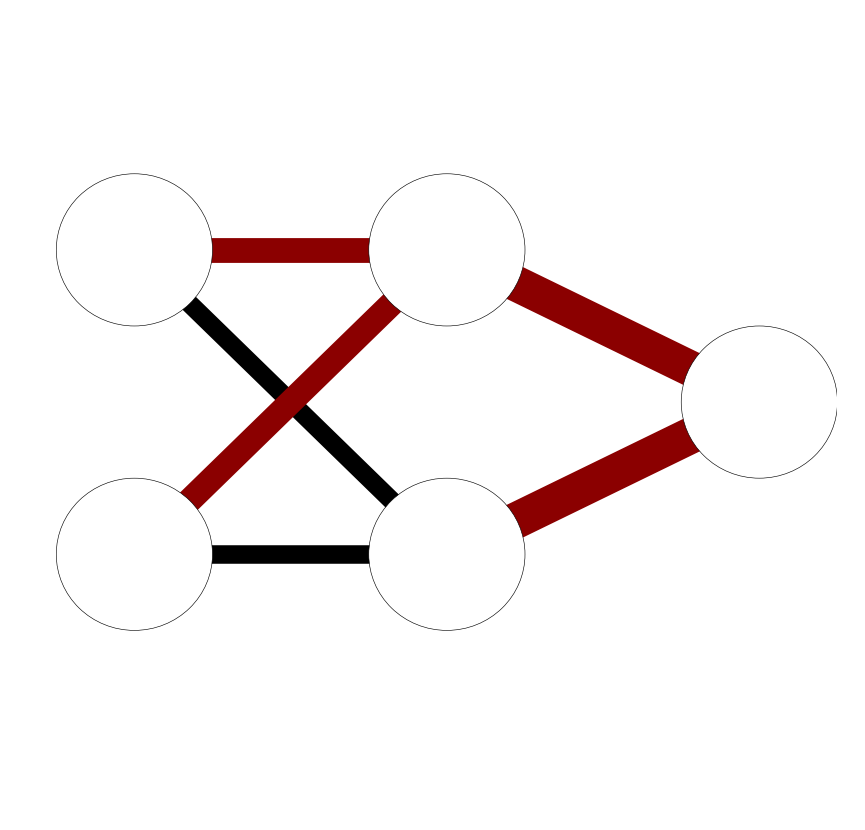

In [48]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis('off')
draw_neural_net(ax, [2, 2, 1], weights=[dn.input_to_hidden, dn.hidden_to_output])
